## Install

In [1]:
!pip3 install torch torchvision numpy

## Imports

In [0]:
from matplotlib import pyplot as plt
import numpy as np

import torch as th
from torch import nn
import torchvision as tv

## Config

In [3]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(f'Using {device}')

image_size = 28 * 28
latent_size = 64
hidden_size = 256
num_epochs = 200
batch_size = 100
learning_rate = 0.0002


Using cuda


## MNIST Dataset

In [0]:
# Download and construct MNIST dataset.
transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
dataset = tv.datasets.MNIST(
    root='~/code/data/mnist/', train=True, transform=transform,
    download=True)

# Data loader (input pipeline)
data_loader = th.utils.data.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=True)

## Model

In [0]:
# Discriminator
discr = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid(),
).to(device)

# Generator
gen = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh(),
).to(device)

# Loss and optimizer.
loss_fn = nn.BCELoss()
d_optimizer = th.optim.Adam(discr.parameters(), lr=learning_rate)
g_optimizer = th.optim.Adam(gen.parameters(), lr=learning_rate)

## Train

In [6]:
# Create labels later used as input for the loss.
REAL_LABELS = th.ones(batch_size, 1).to(device)
FAKE_LABELS = th.zeros(batch_size, 1).to(device)

def discriminator_step(images):
  # Compute loss using real images.
  p_real = discr(images)
  d_loss_real = loss_fn(p_real, REAL_LABELS)
  
  # Compute loss using fake images.
  z = th.randn(batch_size, latent_size).to(device)
  fake_images = gen(z)
  p_fake = discr(fake_images)
  d_loss_fake = loss_fn(p_fake, FAKE_LABELS)

  # Backprop and optimize.
  d_loss = d_loss_real + d_loss_fake
  d_optimizer.zero_grad()
  d_loss.backward()
  d_optimizer.step()
  return d_loss, p_real, p_fake, fake_images

def generator_step():
  # Compute D loss using fake images.
  z = th.randn(batch_size, latent_size).to(device)
  fake_images = gen(z)
  p_fake = discr(fake_images)
  
  # Train G to maximize log(D(G(z))) instead of minimizing log(1 - D(G(z))).
  # See https://arxiv.org/pdf/1406.2661.pdf, section 3, last paragraph.
  g_loss = loss_fn(p_fake, REAL_LABELS)
  
  # Backprop and optimize.
  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()
  return g_loss

import collections
Samples = collections.namedtuple('Samples', ['images', 'p_real'])

image_samples = {}
def save_images(epoch, images, p_fake):
  images = images.reshape(-1, 1, 28, 28)
  images = (images + 1) / 2
  images = images.clamp(0, 1)
  image_samples[epoch] = Samples(images.detach().cpu().numpy(),
                                 p_fake.detach().cpu().numpy())

num_steps = len(data_loader)
for epoch in range(num_epochs):
  for step, (images, _) in enumerate(data_loader):
    images = images.reshape(batch_size, -1).to(device)

    d_loss, p_real, p_fake, fake_images = discriminator_step(images)
    g_loss = generator_step()

  print(f'Epoch [{epoch+1}/{num_epochs}], '
        f'g_loss: {g_loss.item():.4f}, '
        f'd_loss: {d_loss.item():.4f}, '
        f'D(x): {p_real.mean().item():.4f}, '
        f'D(G(z)): {p_fake.mean().item():.4f}')
  
  save_images(epoch, fake_images, p_real)

Epoch [1/200], g_loss: 4.6183, d_loss: 0.0753, D(x): 0.9634, D(G(z)): 0.0352
Epoch [2/200], g_loss: 4.6839, d_loss: 0.1855, D(x): 0.9523, D(G(z)): 0.0691
Epoch [3/200], g_loss: 2.9881, d_loss: 1.6480, D(x): 0.5793, D(G(z)): 0.2840
Epoch [4/200], g_loss: 2.8668, d_loss: 0.4759, D(x): 0.8373, D(G(z)): 0.1474
Epoch [5/200], g_loss: 3.1341, d_loss: 1.0798, D(x): 0.8361, D(G(z)): 0.3916
Epoch [6/200], g_loss: 2.8024, d_loss: 0.3648, D(x): 0.8983, D(G(z)): 0.1838
Epoch [7/200], g_loss: 3.0100, d_loss: 0.2017, D(x): 0.9432, D(G(z)): 0.0975
Epoch [8/200], g_loss: 4.1545, d_loss: 0.2196, D(x): 0.9215, D(G(z)): 0.0830
Epoch [9/200], g_loss: 4.0090, d_loss: 0.0947, D(x): 0.9648, D(G(z)): 0.0222
Epoch [10/200], g_loss: 5.1405, d_loss: 0.2695, D(x): 0.9269, D(G(z)): 0.0599
Epoch [11/200], g_loss: 3.8376, d_loss: 0.2905, D(x): 0.8973, D(G(z)): 0.0577
Epoch [12/200], g_loss: 3.9997, d_loss: 0.3721, D(x): 0.9592, D(G(z)): 0.1913
Epoch [13/200], g_loss: 4.0549, d_loss: 0.1705, D(x): 0.9835, D(G(z)): 0.

Epoch [51/200], g_loss: 3.3919, d_loss: 0.6186, D(x): 0.7166, D(G(z)): 0.0728
Epoch [52/200], g_loss: 3.2929, d_loss: 0.2782, D(x): 0.8634, D(G(z)): 0.0706
Epoch [53/200], g_loss: 3.1596, d_loss: 0.5489, D(x): 0.7796, D(G(z)): 0.1007
Epoch [54/200], g_loss: 2.5225, d_loss: 0.5160, D(x): 0.8268, D(G(z)): 0.1437
Epoch [55/200], g_loss: 2.9611, d_loss: 0.6614, D(x): 0.7253, D(G(z)): 0.1005
Epoch [56/200], g_loss: 1.7895, d_loss: 0.7120, D(x): 0.8138, D(G(z)): 0.2560
Epoch [57/200], g_loss: 2.6572, d_loss: 0.5379, D(x): 0.7598, D(G(z)): 0.0982
Epoch [58/200], g_loss: 2.1951, d_loss: 0.6555, D(x): 0.8512, D(G(z)): 0.2917
Epoch [59/200], g_loss: 2.8693, d_loss: 0.7069, D(x): 0.7560, D(G(z)): 0.1863
Epoch [60/200], g_loss: 2.3504, d_loss: 0.4568, D(x): 0.8408, D(G(z)): 0.1587
Epoch [61/200], g_loss: 2.0824, d_loss: 0.6489, D(x): 0.7699, D(G(z)): 0.1817
Epoch [62/200], g_loss: 2.6412, d_loss: 0.6877, D(x): 0.7603, D(G(z)): 0.2203
Epoch [63/200], g_loss: 1.5549, d_loss: 0.7790, D(x): 0.7312, D(

Epoch [101/200], g_loss: 2.0499, d_loss: 0.7835, D(x): 0.7055, D(G(z)): 0.2153
Epoch [102/200], g_loss: 1.8444, d_loss: 0.8980, D(x): 0.7141, D(G(z)): 0.2827
Epoch [103/200], g_loss: 1.5841, d_loss: 0.7616, D(x): 0.7792, D(G(z)): 0.2908
Epoch [104/200], g_loss: 1.7958, d_loss: 0.8687, D(x): 0.7898, D(G(z)): 0.3354
Epoch [105/200], g_loss: 1.8481, d_loss: 0.9054, D(x): 0.6983, D(G(z)): 0.2470
Epoch [106/200], g_loss: 2.1520, d_loss: 0.7206, D(x): 0.8262, D(G(z)): 0.2822
Epoch [107/200], g_loss: 1.7500, d_loss: 0.8314, D(x): 0.6872, D(G(z)): 0.2263
Epoch [108/200], g_loss: 2.2171, d_loss: 0.7690, D(x): 0.7283, D(G(z)): 0.2156
Epoch [109/200], g_loss: 1.6876, d_loss: 0.9584, D(x): 0.7772, D(G(z)): 0.3848
Epoch [110/200], g_loss: 2.2652, d_loss: 0.7604, D(x): 0.7124, D(G(z)): 0.1920
Epoch [111/200], g_loss: 1.8961, d_loss: 0.9273, D(x): 0.7290, D(G(z)): 0.3228
Epoch [112/200], g_loss: 1.7809, d_loss: 0.6053, D(x): 0.8194, D(G(z)): 0.2558
Epoch [113/200], g_loss: 1.6039, d_loss: 0.8346, D(x

Epoch [150/200], g_loss: 1.5632, d_loss: 0.8276, D(x): 0.6800, D(G(z)): 0.2306
Epoch [151/200], g_loss: 1.2708, d_loss: 1.0223, D(x): 0.7462, D(G(z)): 0.4065
Epoch [152/200], g_loss: 1.9280, d_loss: 1.0419, D(x): 0.6653, D(G(z)): 0.2891
Epoch [153/200], g_loss: 1.5242, d_loss: 1.1357, D(x): 0.6102, D(G(z)): 0.3027
Epoch [154/200], g_loss: 1.8982, d_loss: 1.0019, D(x): 0.5911, D(G(z)): 0.2406
Epoch [155/200], g_loss: 1.4872, d_loss: 0.8416, D(x): 0.7051, D(G(z)): 0.2922
Epoch [156/200], g_loss: 1.7177, d_loss: 0.9675, D(x): 0.7071, D(G(z)): 0.3352
Epoch [157/200], g_loss: 1.5558, d_loss: 0.9978, D(x): 0.7005, D(G(z)): 0.3369
Epoch [158/200], g_loss: 1.7374, d_loss: 1.0403, D(x): 0.7217, D(G(z)): 0.3602
Epoch [159/200], g_loss: 1.4903, d_loss: 0.8302, D(x): 0.8112, D(G(z)): 0.3646
Epoch [160/200], g_loss: 1.3667, d_loss: 0.9024, D(x): 0.8150, D(G(z)): 0.3900
Epoch [161/200], g_loss: 1.2812, d_loss: 0.7559, D(x): 0.6896, D(G(z)): 0.2267
Epoch [162/200], g_loss: 1.5735, d_loss: 1.0203, D(x

Epoch [199/200], g_loss: 1.6145, d_loss: 0.8428, D(x): 0.6935, D(G(z)): 0.2898
Epoch [200/200], g_loss: 1.4914, d_loss: 1.0054, D(x): 0.7125, D(G(z)): 0.3535


## Visualize

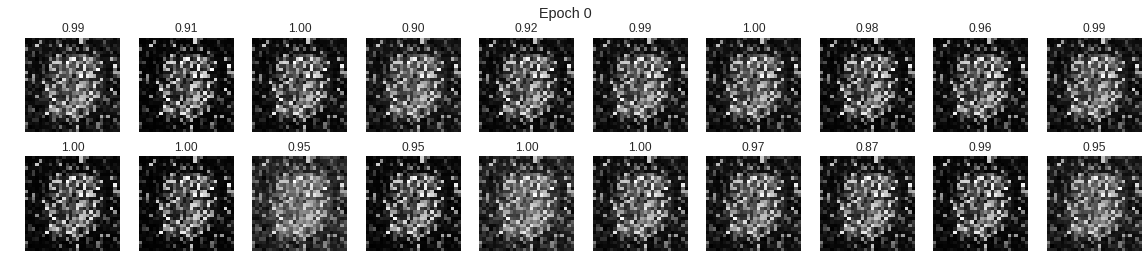

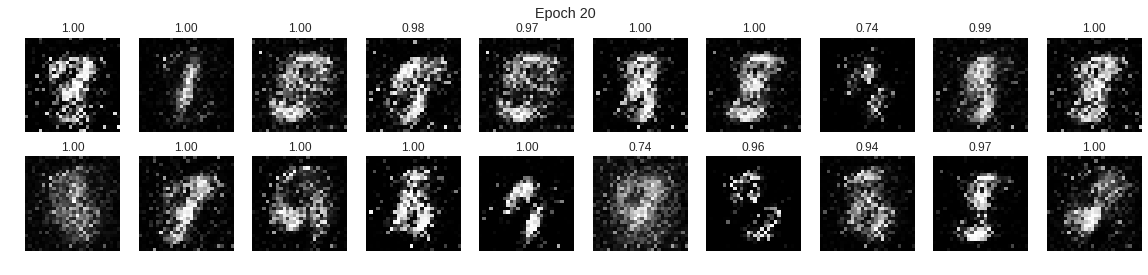

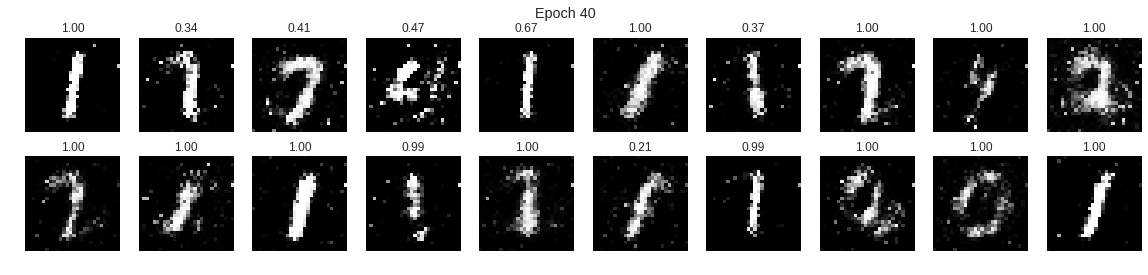

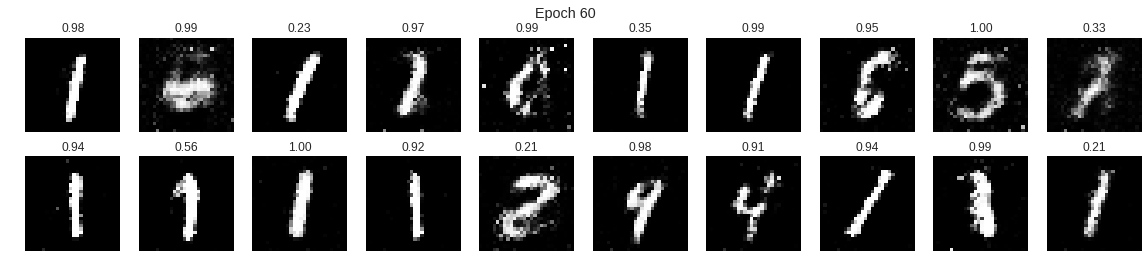

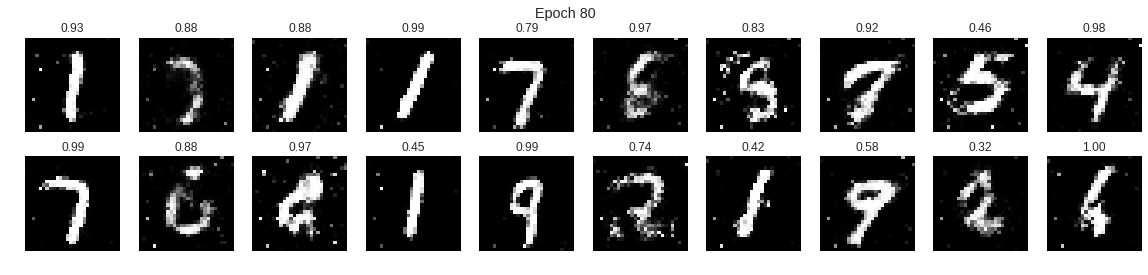

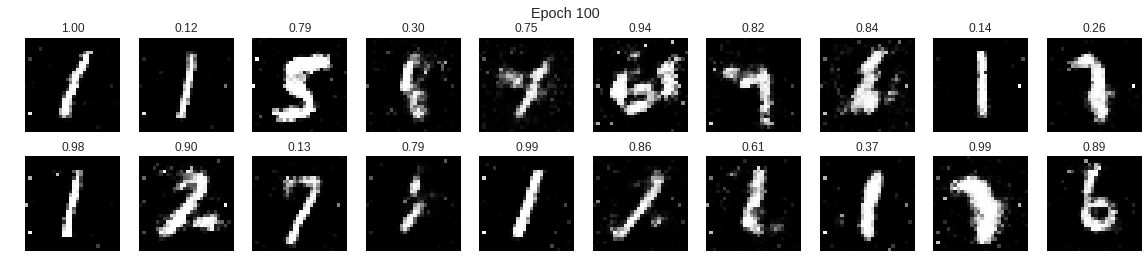

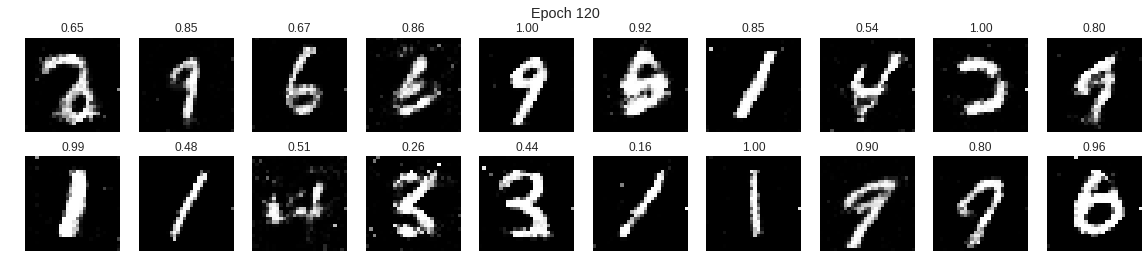

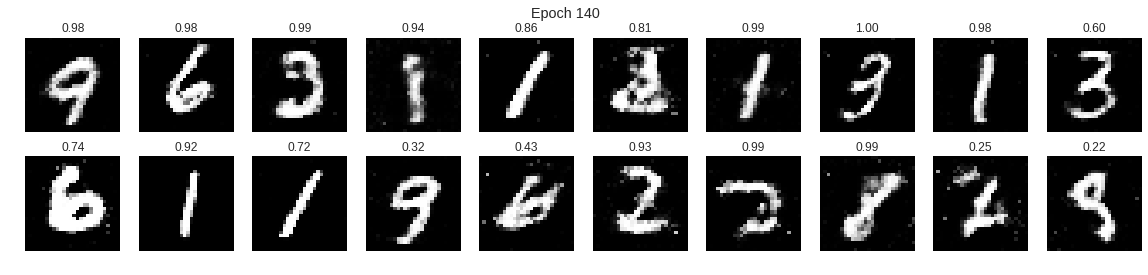

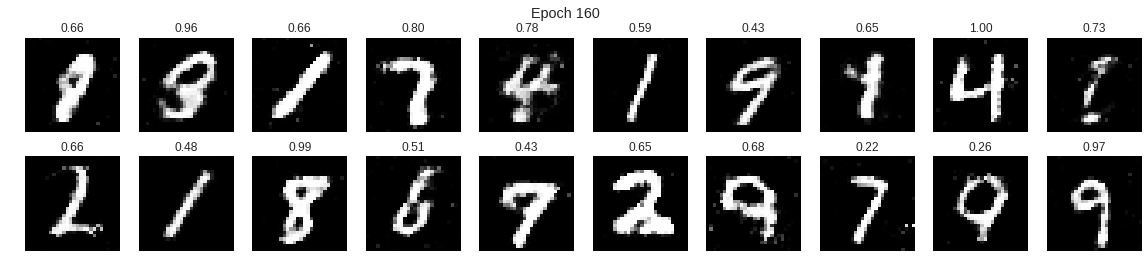

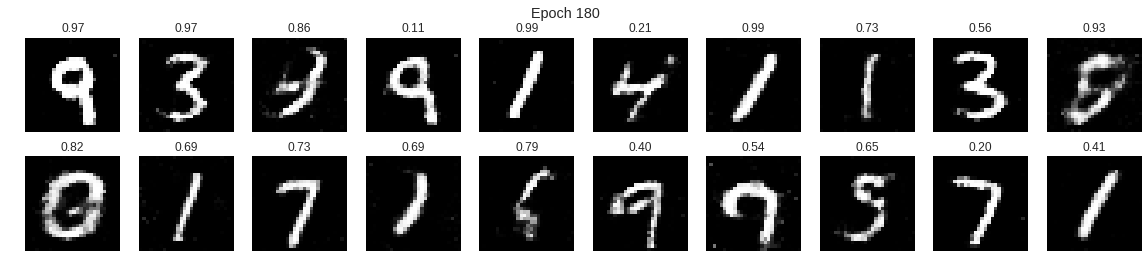

In [7]:
def visualize_epoch(epoch, rows=10, cols=10):
  fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
  fig.suptitle(f'Epoch {epoch}')
  samples = image_samples[epoch]
  for r in range(rows):
    for c in range(cols):
      img = samples.images[r * cols + c, :, :, :].squeeze()
      p_real = samples.p_real[r * cols + c, 0]
      axes[r, c].imshow(img, cmap='gray')
      axes[r, c].set_title(f'{p_real:.2f}')
      axes[r, c].axis('off')

for epoch in range(0, num_epochs, 20):
  visualize_epoch(epoch, rows=2)

## Save model

In [0]:
th.save(gen.state_dict(), '/tmp/generator.ckpt')
th.save(discr.state_dict(), '/tmp/discriminator.ckpt')